**Importing libraries**

In [1]:
import random
import os
import numpy as np
from scipy.io import wavfile as wav
from scipy.signal import spectrogram
from librosa.feature import mfcc

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense,Bidirectional,LSTM
from tensorflow.keras.models import Model

**Define Data Loader**

In [2]:
# Data loader
def load_data(feature_extractor, normalize=False):

    speaker_labels = []
    num_labels = []
    features = []
    labels_data = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            sr, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            speaker = str(f.split('_')[1])
            if speaker == "jackson":
                speaker = 1
            elif speaker == "nicolas":
                speaker = 1
            elif speaker == "theo":
                speaker = 1
            elif speaker == "Salvatore":
                speaker = 2
            elif speaker == "Marco":
                speaker = 3

            speaker_labels.append(speaker)
            
            num = int(f.split('_')[0])
            num_labels.append(num)

            labels_data.append((speaker, num))

    # Convert lists in numpy array
    features = np.array(features)
    labels_data = np.array(labels_data)
            
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels_data , test_size=0.2, random_state=42)

    

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test), X_train_mean, X_train_std

# Features

**Frequency features**

In [3]:
def full_mfcc(input, rate = 8000, tsize=50):
    mfc = mfcc(y = input*1.0, sr = rate)
    
    # if less than tsize, add additional necessary zeroes   
    if mfc.shape[1] < tsize:
            pad_width = tsize - mfc.shape[1]
            mfc = np.pad(mfc, pad_width=((0, 0), (0, pad_width)))

    # If more than tsize, trim 
    elif mfc.shape[1] > tsize:
            mfc = mfc[:, :tsize]
    
    
    output = np.transpose(mfc)
    return output

# Loading Data

In [4]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [5]:
# Data loading
X_train, X_test, y_train, y_test, mean, std = load_data(feature_extractor = full_mfcc, normalize=True)

In [6]:
# Reset warnings filter to default behavior
warnings.filterwarnings("default")

In [7]:
# Save features
np.save('mfcc_X_train.npy', X_train)
np.save('mfcc_y_train.npy', y_train)
np.save('mfcc_X_test.npy', X_test)
np.save('mfcc_y_test.npy', y_test)
np.save('mfcc_mean.npy', mean)
np.save('mfcc_std.npy', std)

In [8]:
# Load extracted features
X_train = np.load('mfcc_X_train.npy')
y_train = np.load('mfcc_y_train.npy')
X_test = np.load('mfcc_X_test.npy')
y_test = np.load('mfcc_y_test.npy')

In [9]:
X_train.shape

(1200, 50, 20)

In [10]:
y_test

array([[2, 7],
       [3, 9],
       [1, 2],
       [1, 2],
       [3, 3],
       [1, 5],
       [3, 7],
       [1, 4],
       [2, 8],
       [1, 1],
       [1, 5],
       [2, 9],
       [1, 4],
       [3, 9],
       [2, 0],
       [2, 8],
       [1, 9],
       [3, 4],
       [1, 2],
       [2, 0],
       [1, 7],
       [2, 7],
       [1, 7],
       [3, 8],
       [2, 9],
       [1, 2],
       [1, 9],
       [1, 9],
       [3, 8],
       [2, 8],
       [3, 7],
       [3, 4],
       [2, 8],
       [1, 6],
       [2, 1],
       [3, 2],
       [1, 2],
       [1, 2],
       [2, 7],
       [2, 0],
       [3, 9],
       [1, 2],
       [1, 8],
       [1, 5],
       [3, 7],
       [2, 2],
       [2, 2],
       [3, 2],
       [1, 4],
       [2, 6],
       [3, 4],
       [2, 3],
       [2, 7],
       [2, 8],
       [1, 3],
       [2, 4],
       [3, 0],
       [3, 3],
       [3, 2],
       [3, 6],
       [3, 4],
       [1, 3],
       [3, 3],
       [2, 0],
       [2, 5],
       [3, 3],
       [3,

In [11]:
# Data loading
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
num_speakers=3
num_classes=10

In [23]:
def RNN_model(num_speakers, num_classes):
    inputs = Input(( np.shape(X_train)[1], np.shape(X_train)[2]))

    # Bidirectional LSTM layers
    lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    lstm_2 = Bidirectional(LSTM(64))(lstm_1)

    # Fully connected layers for speaker classification
    dense_speaker = Dense(64, activation='relu')(lstm_2)
    output_speaker = Dense(num_speakers, activation='softmax', name='speaker')(dense_speaker)


    # Fully connected layers for digit recognition
    dense_digit = Dense(128, activation='relu')(lstm_2)
    output_digit = Dense(num_classes, activation='softmax', name='digit')(dense_digit)


    # Model
    combined_model = Model(inputs=[inputs], outputs=[output_speaker, output_digit])
    return combined_model

In [24]:
model = RNN_model(num_speakers, num_classes)
model.compile(optimizer='adam',
              loss={'speaker': 'categorical_crossentropy','digit': 'sparse_categorical_crossentropy'},
              metrics={'speaker': 'categorical_accuracy', 'digit': 'accuracy'})

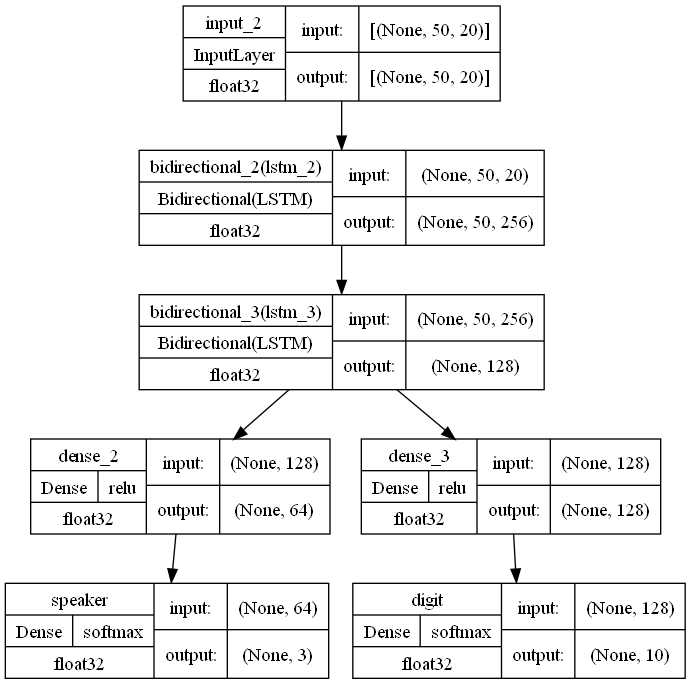

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='RNN.png',show_shapes=True, show_dtype=True, show_layer_activations=True)

In [26]:
le = LabelEncoder()
yS_train = to_categorical(le.fit_transform(y_train[:, 0]))
yS_val = to_categorical(le.fit_transform(y_val[:, 0]))
yS_test = to_categorical(le.fit_transform(y_test[:, 0]))

yD_train = y_train[:, 1]
yD_val = y_val[:, 1]
yD_test = y_test[:, 1]

In [27]:
history = model.fit(X_train,
                  [yS_train, yD_train],
                  validation_data=(X_val,[yS_val, yD_val]), 
                    epochs=20, verbose=1)

Epoch 1/20
30/30 [==============================] - 8s 111ms/step - loss: 2.4682 - speaker_loss: 0.4158 - digit_loss: 2.0523 - speaker_categorical_accuracy: 0.8448 - digit_accuracy: 0.3479 - val_loss: 1.7865 - val_speaker_loss: 0.1572 - val_digit_loss: 1.6292 - val_speaker_categorical_accuracy: 0.9500 - val_digit_accuracy: 0.5458
Epoch 2/20
30/30 [==============================] - 2s 61ms/step - loss: 1.3379 - speaker_loss: 0.1015 - digit_loss: 1.2364 - speaker_categorical_accuracy: 0.9740 - digit_accuracy: 0.6313 - val_loss: 1.0750 - val_speaker_loss: 0.1064 - val_digit_loss: 0.9687 - val_speaker_categorical_accuracy: 0.9792 - val_digit_accuracy: 0.7042
Epoch 3/20
30/30 [==============================] - 2s 60ms/step - loss: 0.8430 - speaker_loss: 0.0542 - digit_loss: 0.7888 - speaker_categorical_accuracy: 0.9823 - digit_accuracy: 0.7437 - val_loss: 0.7914 - val_speaker_loss: 0.0738 - val_digit_loss: 0.7176 - val_speaker_categorical_accuracy: 0.9875 - val_digit_accuracy: 0.7208
Epoch 

In [28]:
y_pred = model.predict(X_test)

yS_pred = np.argmax(y_pred[0], axis = 1)
y_test_ = np.argmax(yS_test, axis = 1)
print(classification_report(y_test_, yS_pred, digits = 3))

10/10 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       104
           1      0.969     0.990     0.979        96
           2      0.990     0.970     0.980       100

    accuracy                          0.987       300
   macro avg      0.986     0.987     0.986       300
weighted avg      0.987     0.987     0.987       300



Confusion matrix:


Text(0.5, 1.0, 'Speakers')

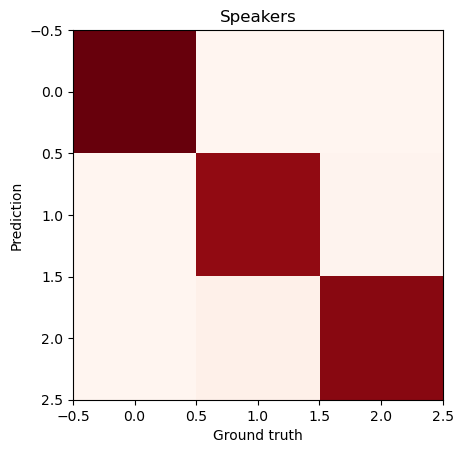

In [29]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test_, yS_pred)
plt.imshow(cm, cmap=plt.cm.Reds);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');
plt.title("Speakers")

In [30]:
yD_pred = np.argmax(y_pred[1], axis = 1)
print(classification_report(yD_test, yD_pred, digits = 3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        28
           1      1.000     0.964     0.982        28
           2      0.944     1.000     0.971        34
           3      1.000     0.903     0.949        31
           4      1.000     0.960     0.980        25
           5      1.000     1.000     1.000        24
           6      0.964     0.964     0.964        28
           7      1.000     1.000     1.000        38
           8      0.950     1.000     0.974        38
           9      0.963     1.000     0.981        26

    accuracy                          0.980       300
   macro avg      0.982     0.979     0.980       300
weighted avg      0.981     0.980     0.980       300



Confusion matrix:


Text(0.5, 1.0, 'Digits')

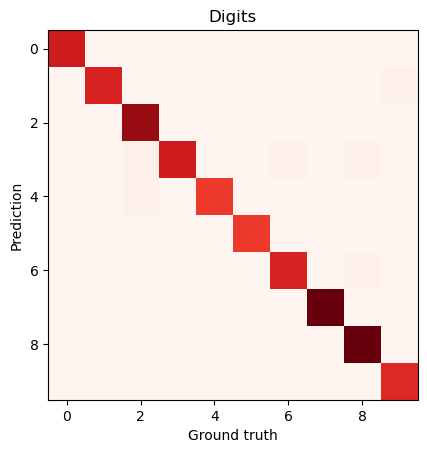

In [31]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(yD_test, yD_pred)
plt.imshow(cm, cmap=plt.cm.Reds);
plt.xlabel('Ground truth');
plt.ylabel('Prediction');
plt.title("Digits")

In [32]:
model_path = os.getcwd() + "\\models\\RNN.h5"

model.save(model_path)